# Typhoon Prediction Project
* Predict the trajectory of typhoons
    * 6h, 12h, 18h, 24h, ...
* LSTM, GRU

In [2312]:
import pandas as pd
# from pandas.core.common import SettingWithCopyWarning
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import geopandas as gpd
from shapely.geometry import LineString
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pd.set_option('mode.chained_assignment', None)
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available. Training on CPU...')
else:
    device = 'cuda'

In [2313]:
DIR_MAP = {'북': 0, '북동':1, '북서': 2, '북북서':3, '북북동':4, '서북서':5, '서':6, '서남서':7, '동북동':8, '남서':9,'남남동':10, '동남동':11, '남남서':12, '동':13, '남':14, '남동':15, -1:-1}

In [2314]:
## 전처리
def rep_nan(data):
    data['진행방향'].fillna(-1, inplace = True)
def drop_str(data):
    cnt=0
    for y,m,d,t in zip(data["Year"],data["Month"],data["Date"],data["Time"]):
            data["Year"][cnt] = y.split("년")[0]
            data["Month"][cnt] = m.split("월")[0]
            data["Date"][cnt] = d.split("일")[0]
            data["Time"][cnt] = t.split("시")[0]
            cnt+=1
    return data
def str2int(data):
    data["Year"]=0
    data["Month"]=0
    data["Date"]=0
    data["Time"]=0
    for i, element in enumerate(data["일시"]):
        data["Year"][i]=element.split(' ')[0]
        data["Month"][i]=element.split(' ')[1]
        data["Date"][i]=element.split(' ')[2]
        data["Time"][i]=element.split(' ')[3]
    return data
def cat_1(data):
    strength_map={}
    for i, s in enumerate(data["강도"].unique()):
        strength_map[s] = i
    data["강도"] = data["강도"].map(strength_map)
    return data
def cat_2(data):
    for i, s in enumerate(data["크기"]):
        if s=="-":
            data["크기"][i] = 0
        elif s=="소형":
            data["크기"][i] = 1
        elif s=="중형":
            data["크기"][i] = 2
        else:
            data["크기"][i] = 3
    return data
def dir_enc(data):
    for i in range(len(data)):
        data["진행방향"][i] = DIR_MAP[data["진행방향"][i]]
def prepro(data):
    idx = data[data["Unnamed: 1"]!=0].index
    data = data.drop(idx)
    data = data.reset_index()
    data = str2int(data)
    drop_str(data)
    data =cat_1(data)
    data =cat_2(data)
    data = data.drop(["70% 확률 반경(km)", "Unnamed: 1","일시","index"], axis=1)
    rep_nan(data)
    dir_enc(data)
    return data
# def prepro2(data):
#     data = dir_enc(data)

In [2315]:
data_dir = "C:/Lab/Capstone/Typhoon/tp_"
data = []

In [2316]:
## csv 순서대로읽어와서 data에 저장
for i in range(1,529):
    data.append(pd.read_csv(data_dir+str(i).zfill(3)+".csv",encoding_errors='ignore',encoding="cp949"))

In [2317]:
Hin = data[521]
Megi = data[512]
del(data[521])
del(data[512])

In [2318]:
for i in range(len(data)):
    data[i]=prepro(data[i])
    #data[i].insert(0,'ID', i)
Hin = prepro(Hin)
Megi = prepro(Megi)

In [2319]:
for i in range(len(data)):
    data[i] = data[i].drop(["Year","Month","Date","Time"],axis=1)
Hin = Hin.drop(["Year","Month","Date","Time"],axis=1)
Megi = Megi.drop(["Year","Month","Date","Time"],axis=1)

In [2320]:
# for i in range(len(data)):
#     data[i] = data[i].drop(["ID"],axis=1)
# Hin = Hin.drop(["ID"],axis=1)

In [2323]:
for i in range(len(data)):
    data[i] = data[i].fillna(-2)

In [2324]:
# sc1 = MinMaxScaler()
# sc2 = MinMaxScaler()

# for i in range(len(data)):
#     data[i][['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']]=sc1.fit_transform(data[i][['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']])
#     data[i][['위도(N)','경도(E)']] = sc2.fit_transform(data[i][['위도(N)','경도(E)']])

In [2325]:
minmax = {}
for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
    m = np.inf
    M = -np.inf
    for i in range(len(data)):
        m = m if np.min(data[i][[j]].values) > m else np.min(data[i][[j]].values)
        # if m == -1 :
            # print(i, end = ' ')
    for i in range(len(data)):
        M = M if np.max(data[i][[j]].values) < M  else np.max(data[i][[j]].values)
    minmax[j] = [m,M]
    print('min', m)
    print('max', M)

min 1.6
max 54.0
min 99.8
max 180.0
min 0
max 1010
min -2.0
max 61
min -4
max 220
min -2.0
max 1480.0
min -2.0
max 216


In [2327]:
minmax['위도(N)'][0], minmax['위도(N)'][1] = 0, 60
minmax['경도(E)'][0], minmax['경도(E)'][1] = 90, 180

for i in range(len(data)):
    for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
        data[i][j] = (data[i][j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

# for i in range(len(data)):
#     for j in ['중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
#         data[i][j] = (data[i][j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

### With_padding

In [2328]:
# for i in range(len(data)):
#     pad = nn.ConstantPad2d((0,0,0,max-data[i].shape[0]),0)
#     data[i]=pad(torch.tensor(data[i].values, dtype=torch.float32))

# y=[]
# for i in range(len(data)):
#     y.append(data[i][:,0:2])

# for i in range(len(data)):
#     data[i] = data[i][:,2:]

### Without_padding

In [2329]:
y=[]
for i in range(len(data)):
    y.append(pd.concat([data[i][:]['위도(N)'],data[i][:]['경도(E)']],axis=1))

for i in range(len(data)):
    data[i] = data[i].drop(['위도(N)','경도(E)'], axis=1)

for i in range(len(data)):
    data[i] = torch.tensor(data[i].values, dtype=torch.float32)
    y[i] = torch.tensor(y[i].values, dtype=torch.float32)


In [2330]:
y[0]

tensor([[ 0.0050, -0.9964],
        [ 0.0054, -0.9962],
        [ 0.0061, -0.9960]])

In [2331]:
x_train, x_valid, y_train, y_valid = train_test_split(data, y, test_size=0.1,shuffle=False)

# 전처리 끝

In [2332]:
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]
    
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=10)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=10)
    
    return xx_pad, yy_pad

In [2333]:
class my_dataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.target = y
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, i):
        return self.data[i], self.target[i]

In [2334]:
batch_size = 32
input_size = 8
hidden_size = 128
num_layer = 2
output_size = 2
MAX_LENGTH = 74
# embedding_size = 32

In [2335]:
train_dataset = my_dataset(x_train, y_train)
valid_dataset = my_dataset(x_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size, shuffle=False, collate_fn = pad_collate)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, collate_fn = pad_collate)

### Encoder

In [2336]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,num_layer,batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.num_layer = num_layer
        self.gru = nn.GRU(input_size, hidden_size,num_layer, batch_first=True)
        
        self.ln = nn.LayerNorm(hidden_size)
         
        self.dropout= nn.Dropout(0.3)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)
        # output = self.ln(output)
        
        hidden = self.ln(hidden)

        return output, hidden
        
    def initHidden(self,num_layer,batch_size):
        return torch.zeros(num_layer,batch_size,self.hidden_size)

### Decoder

In [2337]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, num_layer, batch_size):
        super(DecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layer = num_layer
        
        self.gru = nn.GRU(output_size, hidden_size,num_layer, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.ln = nn.LayerNorm(hidden_size)
        
        self.relu = nn.ReLU(True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.bn = nn.InstanceNorm1d(hidden_size)
        
        #self.bn = nn.BatchNorm1d(hidden_size)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)
        
        # hidden = self.ln(hidden)
        output = self.ln(output)
        
        output = self.relu(self.bn(self.fc1(output)))
        
        output = self.dropout(output)
        
        output = self.fc2(output)
        
        output = self.relu(output)
        
        return output, hidden
    
    def initHidden(self, num_layer, batch_size):
        return torch.zeros(num_layer,batch_size,self.hidden_size)

## Bi

In [2338]:
# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size,num_layer,batch_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.input_size = input_size
#         self.batch_size = batch_size
#         self.num_layer = num_layer
#         self.gru = nn.GRU(input_size, hidden_size,num_layer, batch_first=True, bidirectional=True)
        
#         self.ln = nn.LayerNorm(hidden_size)
         
#         self.dropout= nn.Dropout(0.3)
        
#     def forward(self, input, hidden):
        
#         output, hidden = self.gru(input, hidden)
#         # output = self.ln(output)

#         # hidden = self.dropout(hidden)
        
#         hidden = self.ln(hidden)

#         return output, hidden
        
#     def initHidden(self,num_layer,batch_size):
#         return torch.zeros(2*num_layer, batch_size, self.hidden_size)

In [2339]:
# class DecoderRNN(nn.Module):
#     def __init__(self, output_size, hidden_size, num_layer, batch_size):
#         super(DecoderRNN, self).__init__()
#         self.output_size = output_size
#         self.hidden_size = hidden_size
#         self.batch_size = batch_size
#         self.num_layer = num_layer
        
#         self.gru = nn.GRU(output_size, hidden_size,num_layer, batch_first=True, bidirectional=True)
        
#         self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        
#         self.fc2 = nn.Linear(hidden_size, output_size)
        
#         self.ln = nn.LayerNorm(hidden_size*2)
        
#         self.relu = nn.ReLU(True)
        
#         self.dropout = nn.Dropout(0.3)
        
#         self.bn = nn.InstanceNorm1d(hidden_size)
        
#         #self.bn = nn.BatchNorm1d(hidden_size)
        
#     def forward(self, input, hidden):
        
#         output, hidden = self.gru(input, hidden)
        
#         # hidden = self.dropout(hidden)
        
#         # hidden = self.ln(hidden)
#         output = self.ln(output)
        
#         # output = self.dropout(output)
        
#         output = self.relu(self.bn(self.fc1(output)))
        
#         output = self.dropout(output)
        
#         output = self.fc2(output)
        
#         output = self.relu(output)
        
#         return output, hidden
    
#     def initHidden(self, num_layer, batch_size):
#         return torch.zeros(2*num_layer,batch_size,self.hidden_size)

### Linear

In [2340]:
encoder = EncoderRNN(input_size, hidden_size, num_layer, batch_size)
decoder = DecoderRNN(output_size, hidden_size, num_layer, batch_size)

In [2341]:
encoder

EncoderRNN(
  (gru): GRU(8, 128, num_layers=2, batch_first=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [2342]:
decoder

DecoderRNN(
  (gru): GRU(2, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)

In [2343]:
def mse_loss(data, target, ignored_index):
    mask = (target == ignored_index)
    o_loss = nn.MSELoss(reduction = 'mean')
    m_data = data[~mask]
    m_target = target[~mask]
    loss = o_loss(m_data, m_target)
    return loss

In [2344]:
epoch = 200
teacher_forcing_ratio = 0.5
learning_rate = 0.001
# embeder = Emb(hidden_size, output_size)
encoder.to(device)
decoder.to(device)
# embeder.to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr = learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr = learning_rate)
# embeder_optimizer = optim.Adam(embeder.parameters(), lr = learning_rate)
# scheduler1 = optim.lr_scheduler.StepLR(encoder_optimizer,step_size=400,gamma=0.1,verbose=True)
# scheduler2 = optim.lr_scheduler.StepLR(decoder_optimizer,step_size=400,gamma=0.1,verbose=True)

criterion = mse_loss

# Save training loss
train_loss = torch.zeros(epoch)
valid_loss_min = np.Inf
# Save validation loss
valid_loss = torch.zeros(epoch)
for e in trange(epoch):
    encoder.train()
    decoder.train()
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        # print(type(data))

        encoder_hidden = encoder.initHidden(num_layer,label.shape[0])
        encoder_hidden = encoder_hidden.to(device)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        # embeder_optimizer.zero_grad()
        
        input_length = data.size(1)
        target_length = label.size(1)
        
        # encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size).to(device)
        
        
        # Encoder
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(data[:,ei,:].reshape(label.shape[0],1,-1), encoder_hidden)
        # Decoder_init
        d_input = torch.zeros((label.shape[0],1,2)).to(device)
        decoder_input = label[:,0,:].reshape(label.shape[0],1,-1)#d_input
        # print(decoder_input.shape)
        decoder_hidden = encoder_hidden
        # print(decoder_hidden.shape)
        
        # Decoder
        for di in range(1,target_length):
            # print(decoder_input.size(), decoder_hidden.size())
            # print(decoder_input.size(), decoder_hidden.size())
            decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
            
            # print(decoder_input[:,di,:].shape, label[:,di,:].reshape(1,1,-1).shape)
            # output = embeder(decoder_output)
            # print(output.shape)
            # teacher_force = random.random() < teacher_forcing_ratio
            loss=criterion(decoder_output, label[:,di,:].reshape(label.shape[0],1,-1),ignored_index=10)
            decoder_input = label[:,di,:].reshape(label.shape[0],1,-1) #if teacher_force else decoder_output
            # print(decoder_output.shape)
            train_loss[e] += loss.item()
        loss.backward(retain_graph = True)
        encoder_optimizer.step()
        decoder_optimizer.step()
        # embeder_optimizer.step()
    train_loss[e] /= len(train_loader)

    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        # embeder.eval()
        for data, label in valid_loader:
            data, label = data.to(device), label.to(device)
            
            encoder_hidden = encoder.initHidden(num_layer,label.shape[0])
            encoder_hidden = encoder_hidden.to(device)

            # encoder_optimizer.zero_grad()
            # decoder_optimizer.zero_grad()
            # embeder_optimizer.zero_grad()

            input_length = data.size(1)
            target_length = label.size(1)

            # encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size).to(device)

            for ei in range(input_length):
                
                # print(data.size(), encoder_hidden.size())
                encoder_output, encoder_hidden = encoder(data[:,ei,:].reshape(label.shape[0],1,-1), encoder_hidden)
                # print(1)
                # encoder_outputs[ei] += encoder_output[0,0]

            d_input = torch.zeros((label.shape[0],1,2)).to(device)
            decoder_input = label[:,0,:].reshape(label.shape[0],1,-1)
            decoder_hidden = encoder_hidden

            for di in range(1,target_length):
                
                decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
                # print(decoder_output.shape, decoder_hidden.shape, label.shape)
                # output = embeder(decoder_output)
                # teacher_force = random.random() < teacher_forcing_ratio
                loss=criterion(decoder_output, label[:,di,:].reshape(label.shape[0],1,-1),ignored_index=10)
                decoder_input = label[:,di,:].reshape(label.shape[0],1,-1)# if teacher_force else decoder_output
                valid_loss[e] += loss.item()
        valid_loss[e] /= len(valid_loader)
        # scheduler1.step()
        # scheduler2.step()
    print(f'Epoch : {e},\ttrain_loss : {train_loss[e]}\tvalid_loss :{valid_loss[e]}')
    if (valid_loss[e] <= valid_loss_min):
        print(f'**********Valid loss decreased ({valid_loss_min:.6f} ==> {valid_loss[e]:.6f})**********')
        valid_loss_min = valid_loss[e]
        torch.save(encoder.state_dict(),'Encoder{}.pt'.format(e))
        torch.save(decoder.state_dict(),'Decoder{}.pt'.format(e))

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 0,	train_loss : 7.735095500946045	valid_loss :4.037733554840088
**********Valid loss decreased (inf ==> 4.037734)**********
Epoch : 1,	train_loss : 5.685212135314941	valid_loss :4.441936016082764
Epoch : 2,	train_loss : 6.263018608093262	valid_loss :5.505041122436523
Epoch : 3,	train_loss : 4.618879318237305	valid_loss :4.348788738250732
Epoch : 4,	train_loss : 4.457771301269531	valid_loss :1.5224308967590332
**********Valid loss decreased (4.037734 ==> 1.522431)**********
Epoch : 5,	train_loss : 3.733285427093506	valid_loss :4.355662822723389
Epoch : 6,	train_loss : 3.32877516746521	valid_loss :1.0080139636993408
**********Valid loss decreased (1.522431 ==> 1.008014)**********
Epoch : 7,	train_loss : 3.9287362098693848	valid_loss :2.1749563217163086
Epoch : 8,	train_loss : 2.3944573402404785	valid_loss :1.3045564889907837
Epoch : 9,	train_loss : 2.643322467803955	valid_loss :2.004889488220215
Epoch : 10,	train_loss : 2.8501479625701904	valid_loss :2.136075258255005
Epoch : 11,

([<matplotlib.lines.Line2D at 0x21a0056d100>],
 [<matplotlib.lines.Line2D at 0x21a0056db80>])

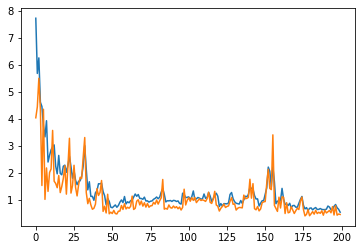

In [2345]:
plt.plot(train_loss),plt.plot(valid_loss)

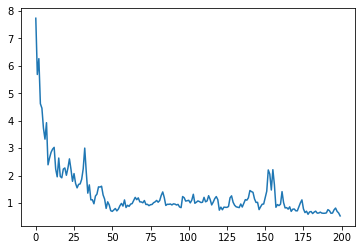

In [2346]:
plt.plot(train_loss)

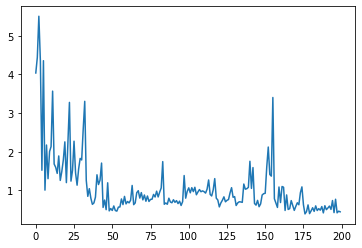

In [2347]:
plt.plot(valid_loss)

In [2378]:
Hin_X = Hin.drop(['위도(N)','경도(E)'],axis=1)
Hin_Y = pd.concat([Hin['위도(N)'],Hin['경도(E)']],axis=1)

Megi_X = Megi.drop(['위도(N)','경도(E)'],axis=1)
Megi_Y = pd.concat([Megi['위도(N)'],Megi['경도(E)']],axis=1)

In [2379]:
for j in ['중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
        Hin_X[j] = (Hin_X[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])
        Megi_X[j] = (Megi_X[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

In [2380]:
for j in ['위도(N)','경도(E)']:
    Hin_Y[j] = (Hin_Y[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])
    Megi_Y[j] = (Megi_Y[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

In [2381]:
Hin_X=Hin_X.values.reshape(-1,44,8).astype(np.float32)
Megi_X=Megi_X.values.reshape(-1,9,8).astype(np.float32)
Hin_Y=Hin_Y.values.reshape(-1,44,2).astype(np.float32)
Megi_Y=Megi_Y.values.reshape(-1,9,2).astype(np.float32)

In [2382]:
Hin_X = torch.tensor(Hin_X, dtype=torch.float32)
Megi_X = torch.tensor(Megi_X, dtype=torch.float32)
Hin_Y = torch.tensor(Hin_Y, dtype=torch.float32)
decoder_inputg = Hin_Y[:,0,:].to(device)
Megi_Y = torch.tensor(Megi_Y, dtype=torch.float32)
decoder_inputm = Megi_Y[:,0,:].to(device)

In [2383]:
Hin_X.shape

torch.Size([1, 44, 8])

In [2395]:
# encoder = EncoderRNN(input_size,hidden_size,batch_size)
# decoder = DecoderRNN()
encoder.load_state_dict(torch.load('./Encoder176.pt'))
decoder.load_state_dict(torch.load('./Decoder176.pt'))

<All keys matched successfully>

In [2397]:
Hin_X = Hin_X.to(device)
hid = encoder.initHidden(2,1)
hid = hid.to(device)
# encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size).to(device)
decode_path = []
# given_path = []
for i in range(Hin_X.shape[1]):
    out, hidden = encoder(Hin_X[:,i,:].reshape(1,1,-1),hid)
    # given_path.append(Hin_Y[:,i,:].reshap(1,1,-1))
    # encoder_outputs[i] += out[0,0]
d_input = torch.zeros((1,1,2)).to(device)
decoder_input = decoder_inputg.reshape(1,-1,2) #d_input
decode_path.append(decoder_input)
decoder_hidden = hidden

# decode_path.append(decoder_input)
for i in range(1,Hin_X.shape[1]):
    decoder_output , decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = Hin_Y[:,i,:].reshape(1,1,-1).to(device)#decoder_output#
    decode_path.append(decoder_output)

In [2398]:
len(decode_path)

44

In [2399]:
decode_path[0].squeeze()[0].item()#.to('cpu').detach().numpy()

0.4483333230018616

In [2400]:
path_x=[]
path_y=[]
for i in range(len(decode_path)):
    path_x.append(decode_path[i].squeeze()[0].item()* (minmax['위도(N)'][1] - minmax['위도(N)'][0]) + minmax['위도(N)'][0])
    path_y.append(decode_path[i].squeeze()[1].item()* (minmax['경도(E)'][1] - minmax['경도(E)'][0]) + minmax['경도(E)'][0])

In [2401]:
# path_x=[]
# path_y=[]
# for i in range(len(decode_path)):
#     path_x.append(decode_path[i].squeeze()[0].item())
#     path_y.append(decode_path[i].squeeze()[1].item())

In [2402]:
path_y[0]

148.4999978542328

In [2403]:
path_x = pd.DataFrame(path_x)
path_y = pd.DataFrame(path_y)

In [2404]:
pred1_path = pd.concat([path_x, path_y],axis=1)

In [2405]:
pred1_path.columns=['위도','경도']

In [2406]:
pred1_path

,위도,경도
0,26.899999,148.499998
1,44.474806,139.018797
2,34.671210,139.799733
3,30.257249,142.667910
4,28.995051,144.131774
5,28.598737,144.157174
6,28.540664,143.384430
7,28.584911,142.076928
8,28.731025,140.301864
9,28.772589,138.066060


In [1855]:
pred1_path

,위도,경도
0,26.900000,148.500000
1,35.542919,129.139267
2,35.542480,129.140625
3,35.542938,129.143188
4,35.543114,129.144119
5,35.543175,129.144440
6,35.543198,129.144562
7,35.543209,129.144608
8,35.543209,129.144608
9,35.543213,129.144623


In [1793]:
Megi_Y

tensor([[[0.1817, 0.3989],
         [0.1817, 0.3933],
         [0.1833, 0.3911],
         [0.1833, 0.3889],
         [0.1833, 0.3867],
         [0.1833, 0.3833],
         [0.1883, 0.3844],
         [0.1850, 0.3889],
         [0.1850, 0.3978]]])

C:\Users\jeonjw\anaconda3\envs\jeon\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

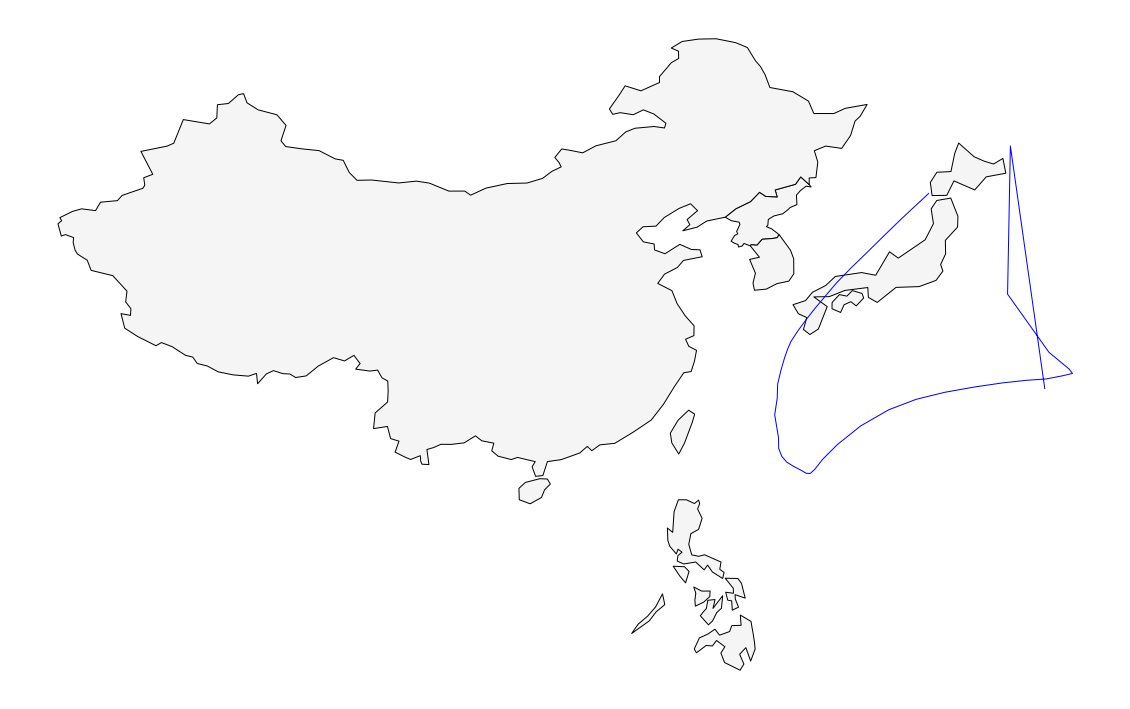

In [2365]:
gdf_path = gpd.GeoDataFrame(pred1_path, geometry=gpd.points_from_xy(pred1_path[:]['경도'],pred1_path[:]['위도']), crs='epsg:4326')
line_geometry = LineString(gdf_path["geometry"])
df_path_line = pd.DataFrame({'geometry' : [line_geometry]})
gdf_path_line = gpd.GeoDataFrame(df_path_line, geometry=df_path_line.geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basemap = world.loc[world['name'].isin(['South Korea', 'North Korea','Japan', 'China', 'Philippines','Taiwan'])]
ax = basemap.plot(figsize=(20,20), color='whitesmoke', edgecolor='black', linewidth=1)
ax.axis('off')
gdf_path_line.plot(ax=ax, linewidth=1., color='blue', zorder=1)

C:\Users\jeonjw\anaconda3\envs\jeon\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

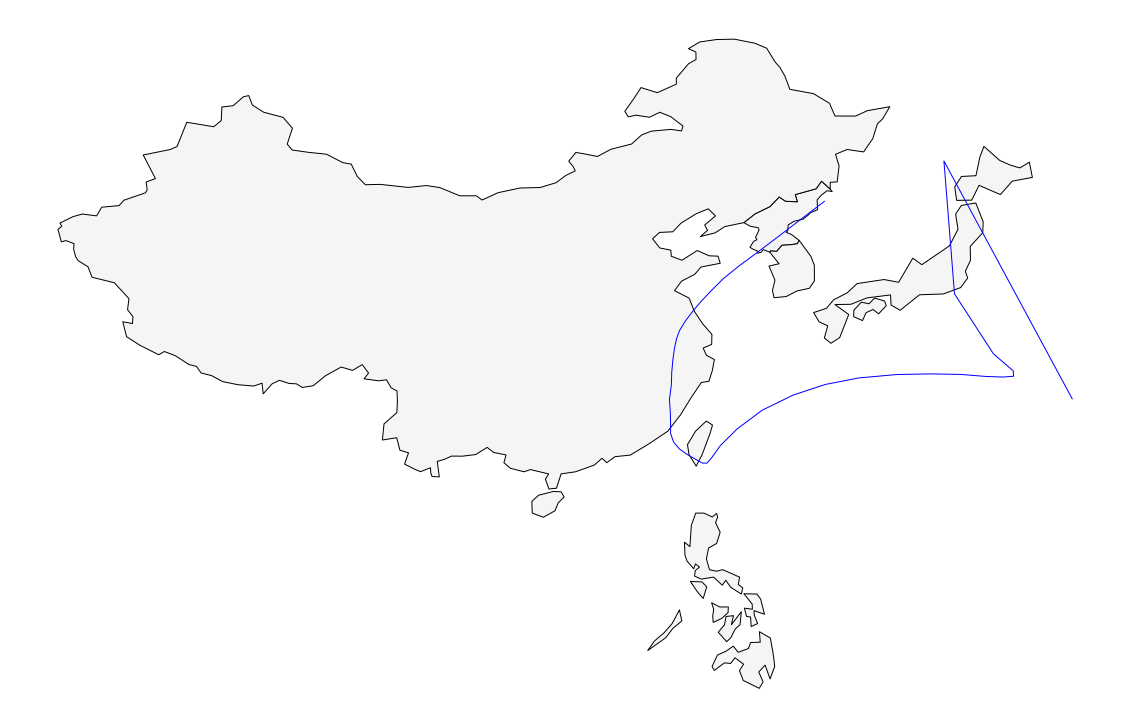

In [2407]:
gdf_path = gpd.GeoDataFrame(pred1_path, geometry=gpd.points_from_xy(pred1_path[:]['경도'],pred1_path[:]['위도']), crs='epsg:4326')
line_geometry = LineString(gdf_path["geometry"])
df_path_line = pd.DataFrame({'geometry' : [line_geometry]})
gdf_path_line = gpd.GeoDataFrame(df_path_line, geometry=df_path_line.geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basemap = world.loc[world['name'].isin(['South Korea', 'North Korea','Japan', 'China', 'Philippines','Taiwan'])]
ax = basemap.plot(figsize=(20,20), color='whitesmoke', edgecolor='black', linewidth=1)
ax.axis('off')
gdf_path_line.plot(ax=ax, linewidth=1., color='blue', zorder=1)

C:\Users\jeonjw\anaconda3\envs\jeon\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

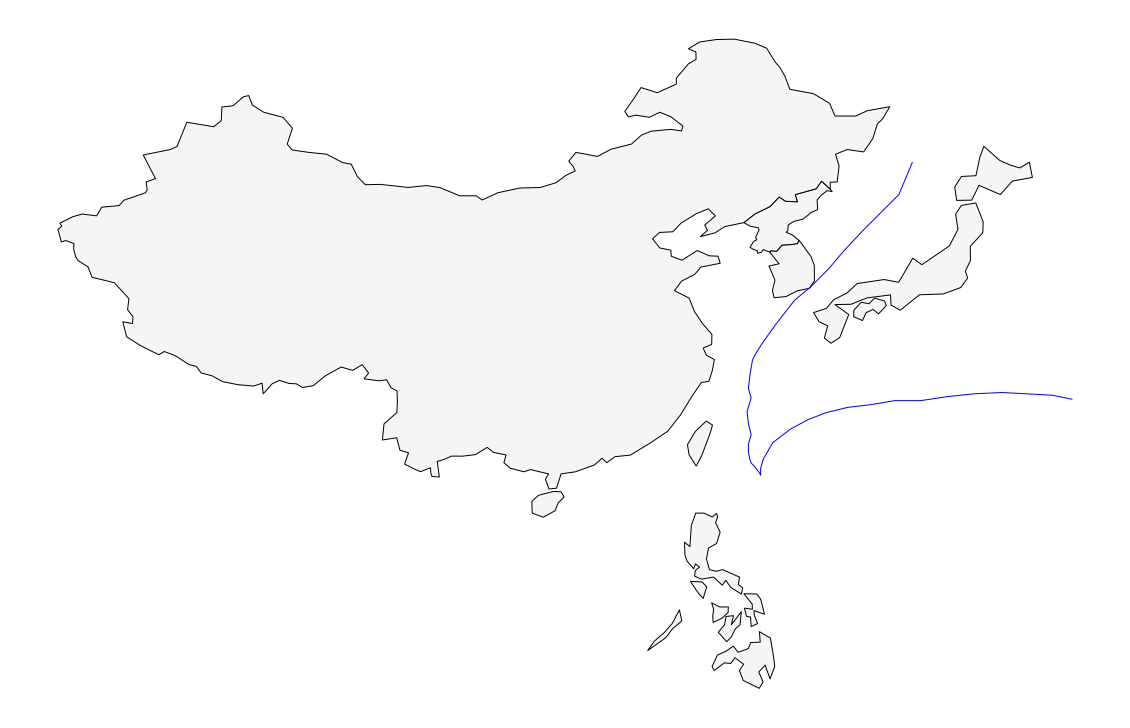

In [97]:
gdf_path = gpd.GeoDataFrame(Hin_Y, geometry=gpd.points_from_xy(Hin_Y[:]['경도(E)'],Hin_Y[:]['위도(N)']), crs='epsg:4326')
line_geometry = LineString(gdf_path["geometry"])
df_path_line = pd.DataFrame({'geometry' : [line_geometry]})
gdf_path_line = gpd.GeoDataFrame(df_path_line, geometry=df_path_line.geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basemap = world.loc[world['name'].isin(['South Korea', 'North Korea','Japan', 'China', 'Philippines','Taiwan'])]
ax = basemap.plot(figsize=(20,20), color='whitesmoke', edgecolor='black', linewidth=1)
ax.axis('off')
gdf_path_line.plot(ax=ax, linewidth=1., color='b', zorder=1)